## Setup ##

In [5]:
"""load modules"""
from augmentem import Augmentor 

import tifffile
import os
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
path = os.path.join(os.path.abspath('../'), 'augmentem')
sys.path.append(path)

import blur
import box 
import circle
import elastic_warp
import flip
import grey
import misalign_slip
import misalign_translation
import missing_section
import noise
import rescale
import rotate
import rotate90
import sin

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


volume type: float32
labels type: float32
volume shape: (5, 512, 512, 1)
labels shape: (5, 512, 512, 1)


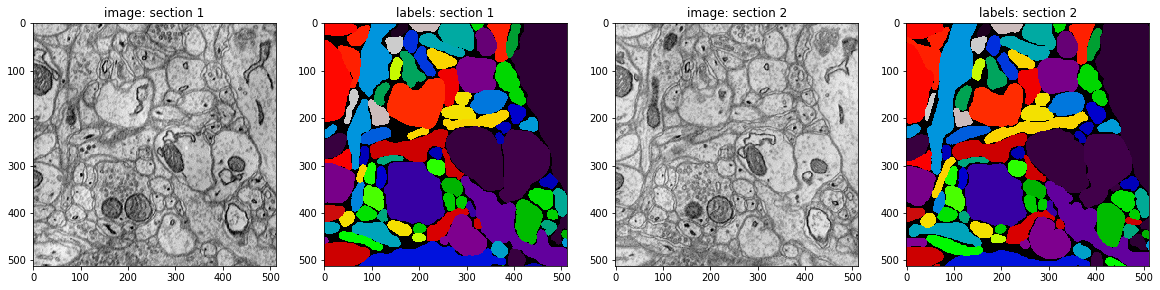

In [6]:
"""load data"""
# This is a subvolume of SNEMI3D training set
data_dir = './'
volume = np.expand_dims(tifffile.imread(os.path.join(data_dir, 'volume.tif')), -1).astype(np.float32)
labels = np.expand_dims(tifffile.imread(os.path.join(data_dir, 'labels.tif')), -1).astype(np.float32)

print('volume type: {}'.format(volume.dtype))
print('labels type: {}'.format(labels.dtype))
print('volume shape: {}'.format(volume.shape))
print('labels shape: {}'.format(labels.shape))

# display
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.title('image: section 1')
plt.imshow(volume[0,:,:,0], cmap='gray')

plt.subplot(142)
plt.title('labels: section 1')
plt.imshow(labels[0,:,:,0], cmap='nipy_spectral')

plt.subplot(143)
plt.title('image: section 2')
plt.imshow(volume[1,:,:,0], cmap='gray')

plt.subplot(144)
plt.title('labels: section 2')
plt.imshow(labels[1,:,:,0], cmap='nipy_spectral')
plt.show()

## Augmentor ##

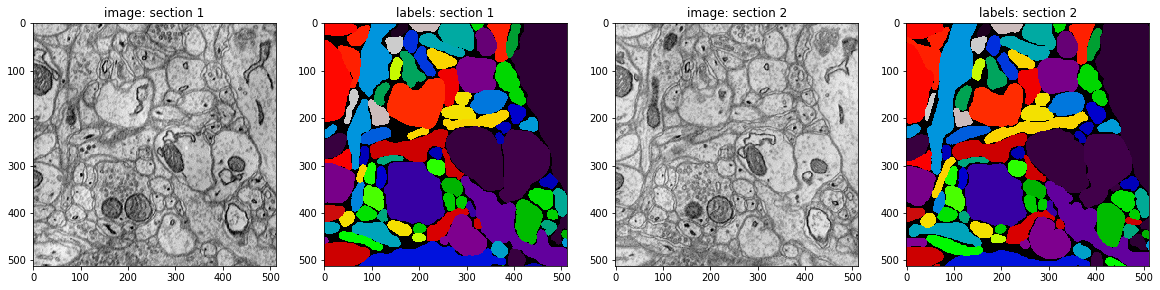

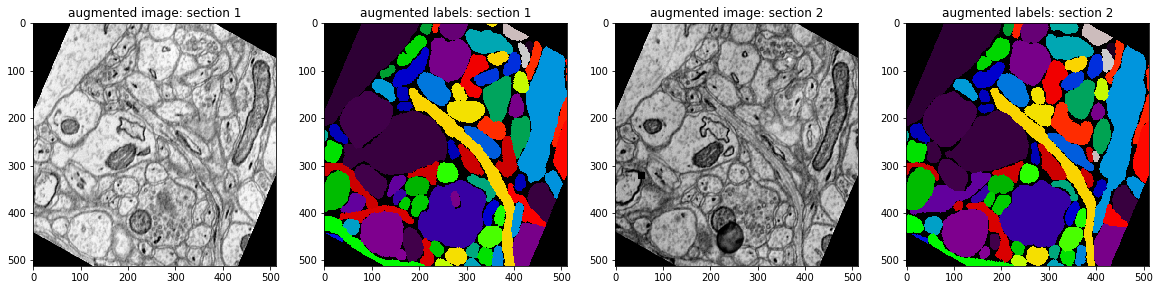

In [12]:
""" General usage:

>>> params = {'rotate': True, 'flip': True, ...}
>>> augmentor = Augmentor(params)
>>> img, [label1, label2, ...] = augmentor(img, [label1, label2, ...])
"""
# augment
params = { 
    'blur': True,
        'blur_prob': 0.01,
        'blur_sigma': 3,
    'box': True,
        'box_n': 10,
        'box_r': 20,
        'box_z': 1,
        'box_fill': 'zero',
    'circle': False,
        'circle_prob': 0.01,
        'circle_radius': 10,
    'elastic_warp': True,
        'elastic_n': 4,
        'elastic_d': 3,
        'elastic_sigma': 5,
    'flip': True,
    'grey': False,
        'grey_contrast': 0.15,
        'grey_brightness': 0.15,
        'grey_gamma': 1.0,
    'misalign_slip': False,
        'misalign_slip_prob': 1.0,
        'misalign_slip_delta': 8,
        'misalign_slip_shift_labels': True,
    'missing_section': True,
        'missing_section_prob': 0.01,
        'missing_section_fill': 'zero',
    'noise': True,
        'noise_sigma': 0.1,
    'rescale': True,
        'rescale_min': 0.8,
        'rescale_max': 1.2,
    'rotate': True,
    'rot90': True,
    'sin': True,
        'sin_a': 0.2,
        'sin_f': 1 / 100.0,
}
augmentor = Augmentor(params)
volume_aug, [labels_aug] = augmentor(volume, [labels])

# plot
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.title('image: section 1')
plt.imshow(volume[0,:,:,0], cmap='gray')

plt.subplot(142)
plt.title('labels: section 1')
plt.imshow(labels[0,:,:,0], cmap='nipy_spectral')

plt.subplot(143)
plt.title('image: section 2')
plt.imshow(volume[1,:,:,0], cmap='gray')

plt.subplot(144)
plt.title('labels: section 2')
plt.imshow(labels[1,:,:,0], cmap='nipy_spectral')
plt.show()

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.title('augmented image: section 1')
plt.imshow(volume_aug[0,:,:,0], cmap='gray')

plt.subplot(142)
plt.title('augmented labels: section 1')
plt.imshow(labels_aug[0,:,:,0], cmap='nipy_spectral')

plt.subplot(143)
plt.title('augmented image: section 2')
plt.imshow(volume_aug[1,:,:,0], cmap='gray')

plt.subplot(144)
plt.title('augmented labels: section 2')
plt.imshow(labels_aug[1,:,:,0], cmap='nipy_spectral')
plt.show()

## Blur ##

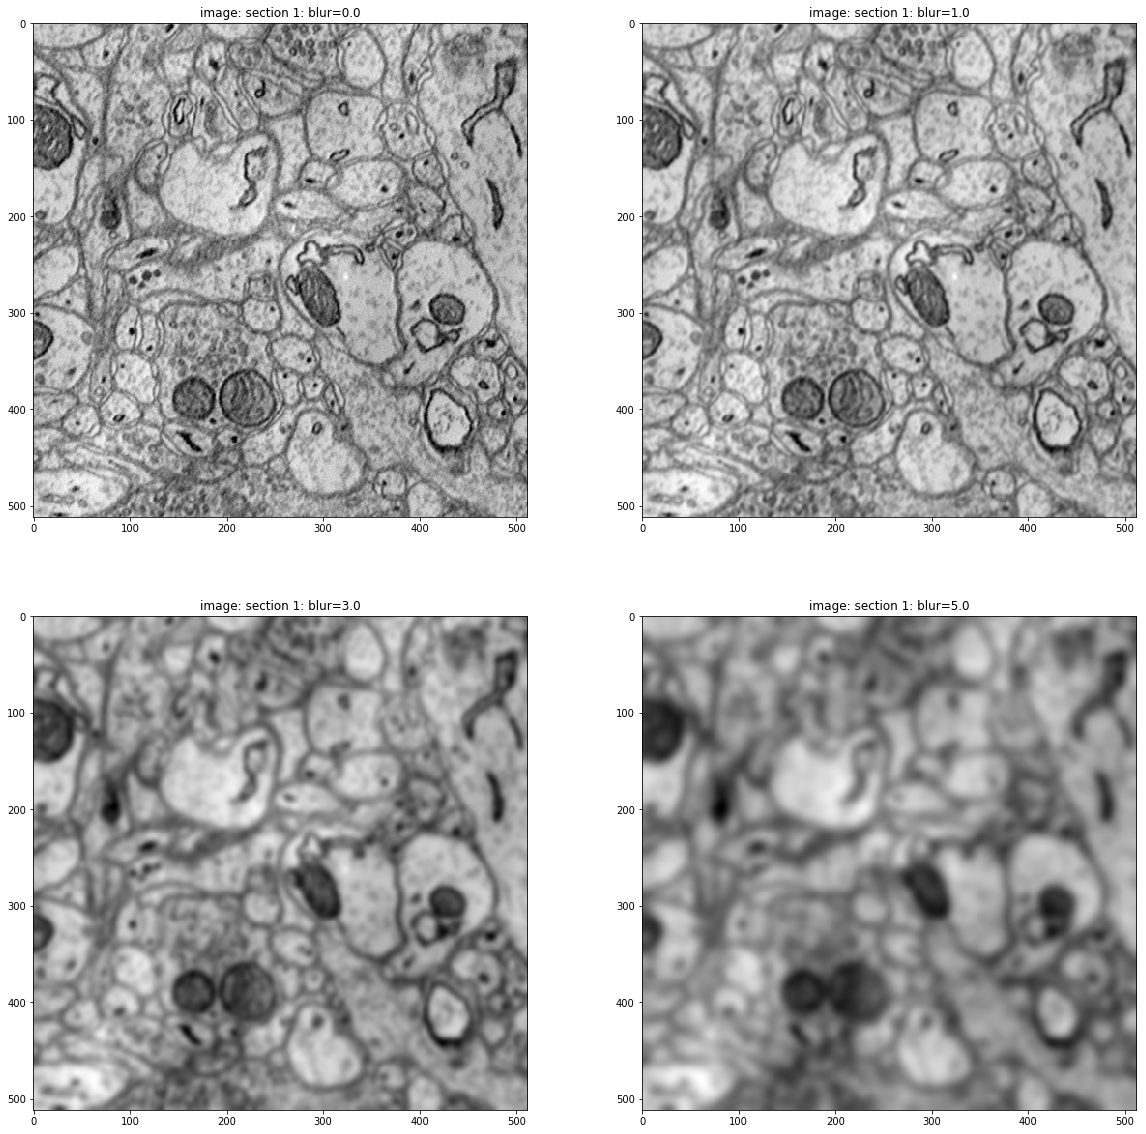

In [16]:
# blur
blur0 = blur.blur(volume[0], 0.0)
blur1 = blur.blur(volume[0], 1.0)
blur3 = blur.blur(volume[0], 3.0)
blur5 = blur.blur(volume[0], 5.0)
    
# plot
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('image: section 1: blur=0.0')
plt.imshow(blur0[:,:,0], cmap='gray')

plt.subplot(222)
plt.title('image: section 1: blur=1.0')
plt.imshow(blur1[:,:,0], cmap='gray')

plt.subplot(223)
plt.title('image: section 1: blur=3.0')
plt.imshow(blur3[:,:,0], cmap='gray')

plt.subplot(224)
plt.title('image: section 1: blur=5.0')
plt.imshow(blur5[:,:,0], cmap='gray')

plt.show()


## Circle ##

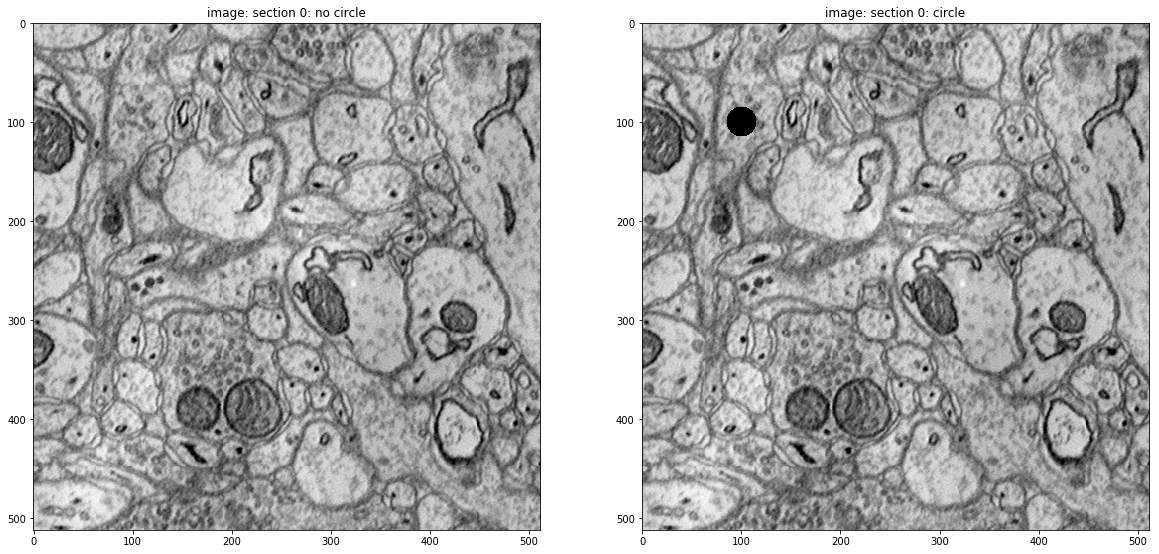

In [17]:
# circle
yc, xc = (100, 100)
r = 15
volume_aug = circle.circle(np.copy(volume[0]), yc, xc, r)

# plot
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('image: section 0: no circle')
plt.imshow(np.squeeze(volume[0]), cmap='gray')

plt.subplot(122)
plt.title('image: section 0: circle')
plt.imshow(np.squeeze(volume_aug), cmap='gray')

plt.show()

## Elastic Warp ##

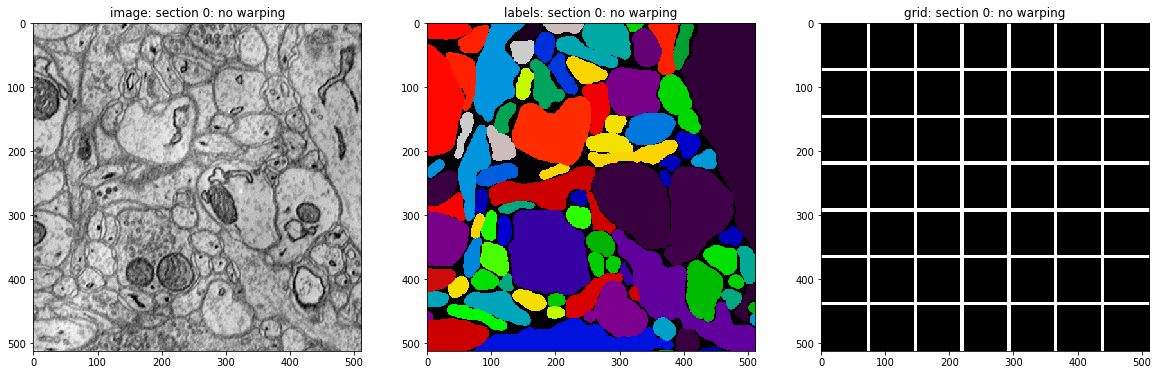

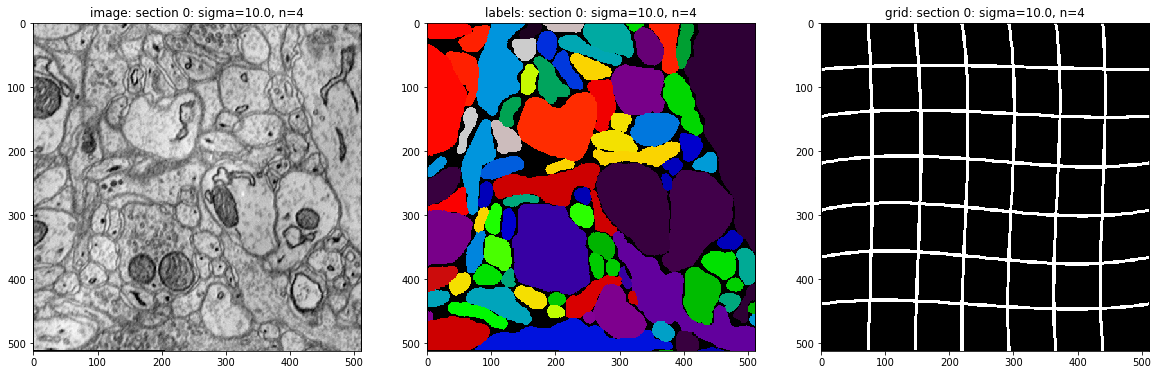

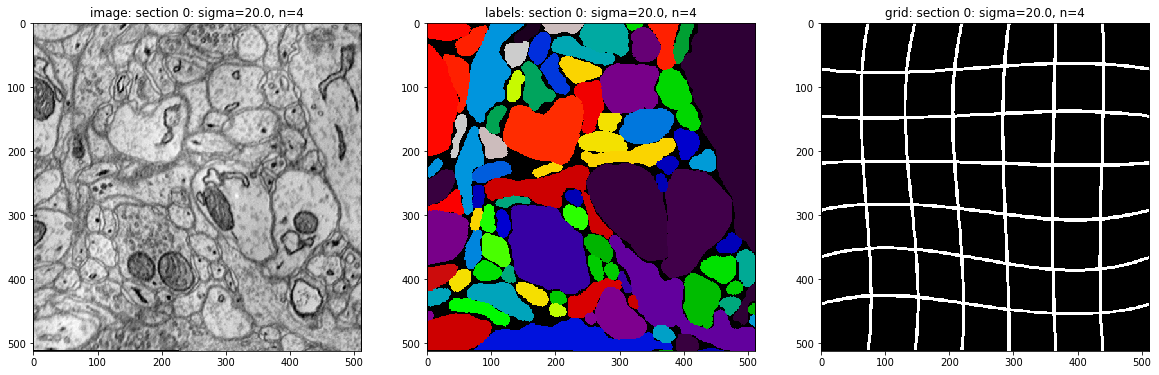

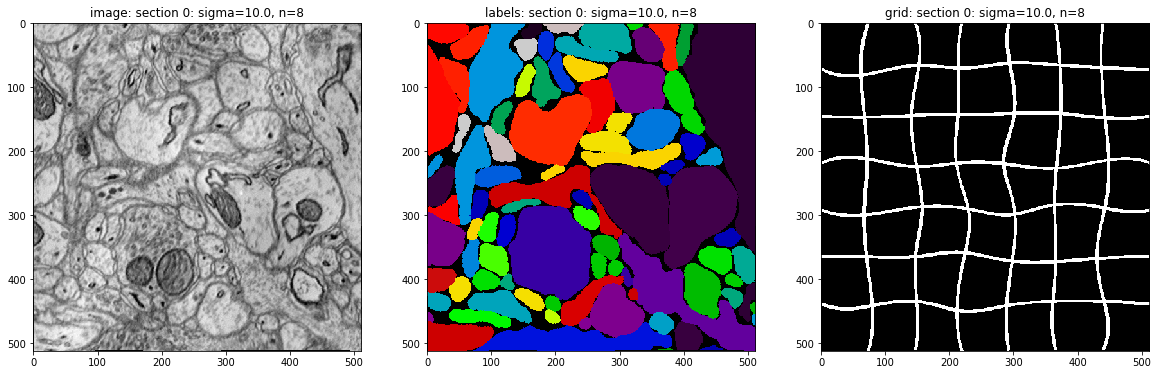

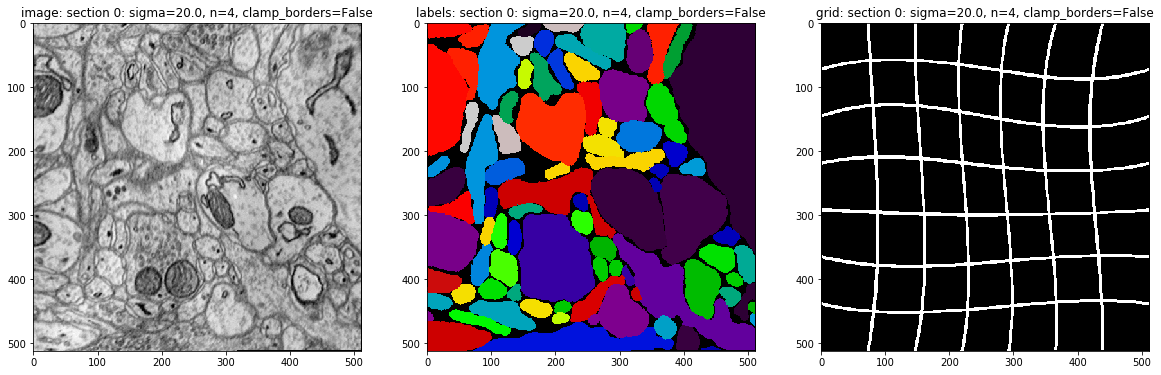

In [21]:
# elastic_warp
def create_grid(z,y,x,ch,m):
    grid = np.zeros((z,y,x,ch))
    xs = np.linspace(0,x-1,m).astype(np.int)[1:-1]
    ys = np.linspace(0,y-1,m).astype(np.int)[1:-1]
    for x in xs:
        grid[:,x-2:x+3,:,0] = 1.0
    for y in ys:
        grid[:,:,y-2:y+3,0] = 1.0
        
    return grid
    
vol = np.copy(volume)
lab = np.copy(labels)
grd = create_grid(*volume.shape, 8)
z = vol.shape[0]

# sigma 10.0
n = 4
sigma = 10.0
clamp_borders = True
dxs, dys = elastic_warp.create_displacements(n, sigma, clamp_borders)

vol10, [lab10, grd10] = elastic_warp.elastic_warp(vol, [lab, grd], [dxs]*z, [dys]*z)

# sigma 20.0
n = 4
sigma = 20.0
clamp_borders = True
dxs, dys = elastic_warp.create_displacements(n, sigma, clamp_borders)

vol20, [lab20, grd20] = elastic_warp.elastic_warp(vol, [lab, grd], [dxs]*z, [dys]*z)

# n=8
n = 8
sigma = 10.0
clamp_borders = True
dxs, dys = elastic_warp.create_displacements(n, sigma, clamp_borders)

vol10_8, [lab10_8, grd10_8] = elastic_warp.elastic_warp(vol, [lab, grd], [dxs]*z, [dys]*z)

# no clamp
n = 4
sigma = 20.0
clamp_borders = True
dxs, dys = elastic_warp.create_displacements(n, sigma, clamp_borders)

vol20_nc, [lab20_nc, grd20_nc] = elastic_warp.elastic_warp(vol, [lab, grd], [dxs]*z, [dys]*z)

# plot 
def plot_grid(vol, lab, grd, suffix):
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.title('image: section 0: {}'.format(suffix))
    plt.imshow(vol[0,:,:,0], cmap='gray')

    plt.subplot(132)
    plt.title('labels: section 0: {}'.format(suffix))
    plt.imshow(lab[0,:,:,0], cmap='nipy_spectral')

    plt.subplot(133)
    plt.title('grid: section 0: {}'.format(suffix))
    plt.imshow(grd[0,:,:,0], cmap='gray')

    plt.show()

plot_grid(vol, lab, grd, 'no warping')
plot_grid(vol10, lab10, grd10, 'sigma=10.0, n=4')
plot_grid(vol20, lab20, grd20, 'sigma=20.0, n=4')
plot_grid(vol10_8, lab10_8, grd10_8, 'sigma=10.0, n=8')
plot_grid(vol20_nc, lab20_nc, grd20_nc, 'sigma=20.0, n=4, clamp_borders=False')

## Flip ## 

In [22]:
vol = np.copy(volume)
lab = np.copy(labels)

vol_fx, [lab_fx] = flip.flip(vol, [lab], 0)
vol_fx, [lab_fx] = flip.flip(vol, [lab], 1)


## Misalign ##

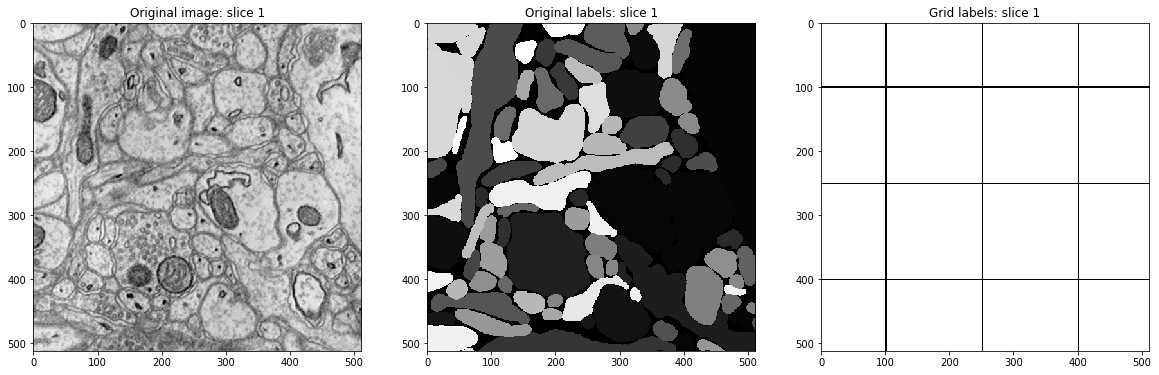

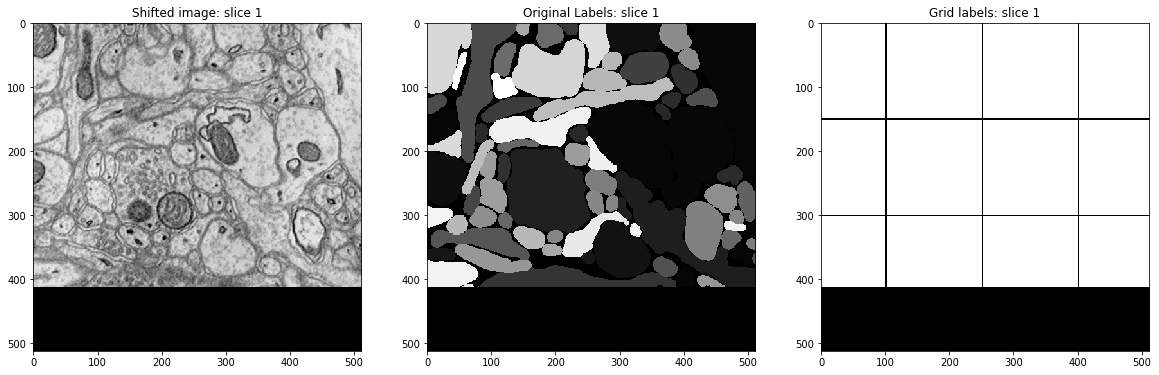

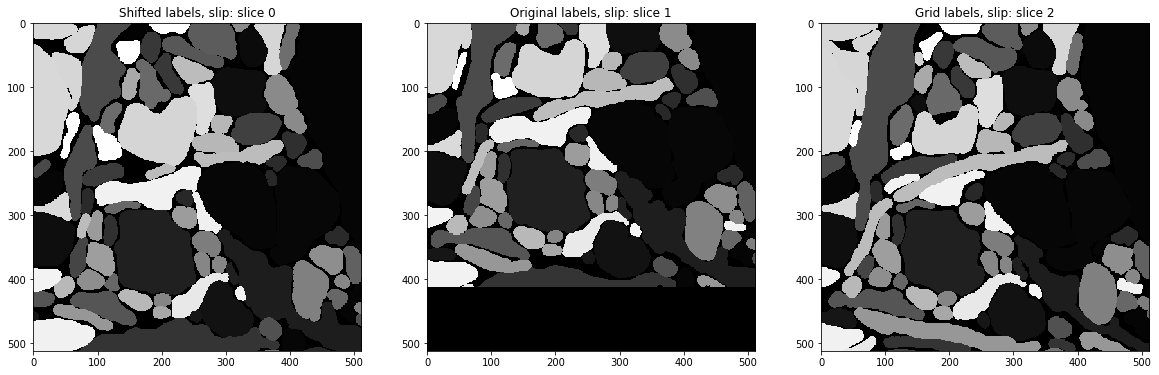

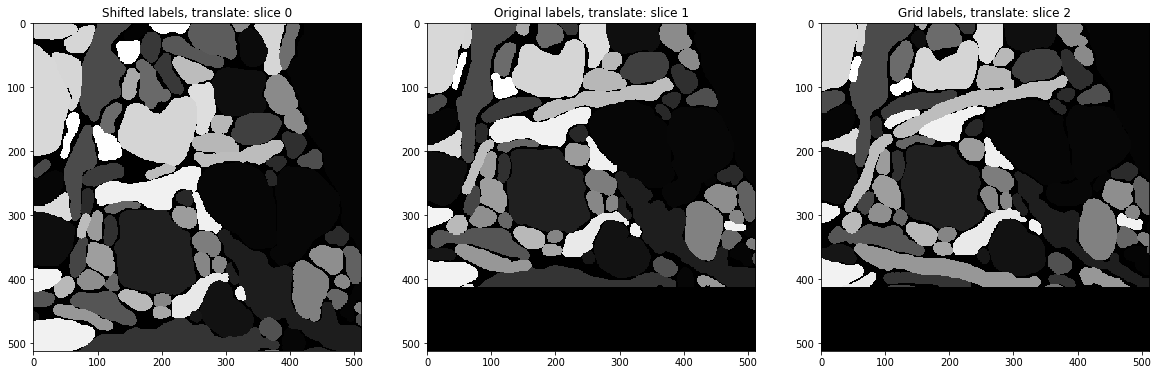

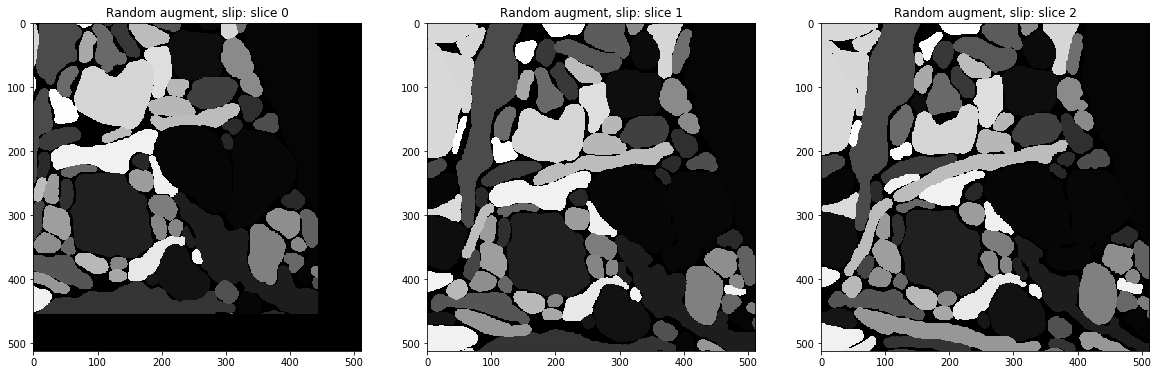

In [33]:
# Original data
img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])
grid = np.ones_like(labs)
grid[:,100:102,:] = grid[:,:,100:102] = grid[:,250:252,:] = grid[:,:,250:252] = grid[:,400:402,:] = grid[:,:,400:402] = 0

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Original image: slice 1')
plt.imshow(np.squeeze(img[1]), cmap='gray')

plt.subplot(132)
plt.title('Original labels: slice 1')
plt.imshow(np.squeeze(labs[1]), cmap='gray')

plt.subplot(133)
plt.title('Grid labels: slice 1')
plt.imshow(np.squeeze(grid[1]), cmap='gray')
plt.show()

# Fixed shift: slip
z = 1
dx = -100
dy = 0
shift_labels = True

img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])
grid = np.ones_like(labs)
grid[:,100:102,:] = grid[:,:,100:102] = grid[:,250:252,:] = grid[:,:,250:252] = grid[:,400:402,:] = grid[:,:,400:402] = 0
img_fx, [labs_fx, grid_fx] = misalign_slip.misalign_slip(img, [labs, grid], z, dx, dy, shift_labels)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Shifted image: slice 1')
plt.imshow(np.squeeze(img_fx[1]), cmap='gray')

plt.subplot(132)
plt.title('Original Labels: slice 1')
plt.imshow(np.squeeze(labs_fx[1]), cmap='gray')

plt.subplot(133)
plt.title('Grid labels: slice 1')
plt.imshow(np.squeeze(grid_fx[1]), cmap='gray')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Shifted labels, slip: slice 0')
plt.imshow(np.squeeze(labs_fx[0]), cmap='gray')

plt.subplot(132)
plt.title('Original labels, slip: slice 1')
plt.imshow(np.squeeze(labs_fx[1]), cmap='gray')

plt.subplot(133)
plt.title('Grid labels, slip: slice 2')
plt.imshow(np.squeeze(labs_fx[2]), cmap='gray')
plt.show()

# Fixed shift: translate
img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])
grid = np.ones_like(labs)
grid[:,100:102,:] = grid[:,:,100:102] = grid[:,250:252,:] = grid[:,:,250:252] = grid[:,400:402,:] = grid[:,:,400:402] = 0
img_fx, [labs_fx, grid_fx] = misalign_translation.misalign_translation(img, [labs, grid], z, dx, dy, shift_labels)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Shifted labels, translate: slice 0')
plt.imshow(np.squeeze(labs_fx[0]), cmap='gray')

plt.subplot(132)
plt.title('Original labels, translate: slice 1')
plt.imshow(np.squeeze(labs_fx[1]), cmap='gray')

plt.subplot(133)
plt.title('Grid labels, translate: slice 2')
plt.imshow(np.squeeze(labs_fx[2]), cmap='gray')
plt.show()

# Random Augmentation
img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])
grid = np.ones_like(labs)
grid[:,100:102,:] = grid[:,:,100:102] = grid[:,250:252,:] = grid[:,:,250:252] = grid[:,400:402,:] = grid[:,:,400:402] = 0

p = 1.0
delta = 100
shift_labels = True
img_fx, [labs_fx, grid_fx] = misalign_slip.misalign_slip_augment(img, [labs, grid], p, delta, shift_labels)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Random augment, slip: slice 0')
plt.imshow(np.squeeze(labs_fx[0]), cmap='gray')

plt.subplot(132)
plt.title('Random augment, slip: slice 1')
plt.imshow(np.squeeze(labs_fx[1]), cmap='gray')

plt.subplot(133)
plt.title('Random augment, slip: slice 2')
plt.imshow(np.squeeze(labs_fx[2]), cmap='gray')
plt.show()

## Missing Section ##

## Rescale ##

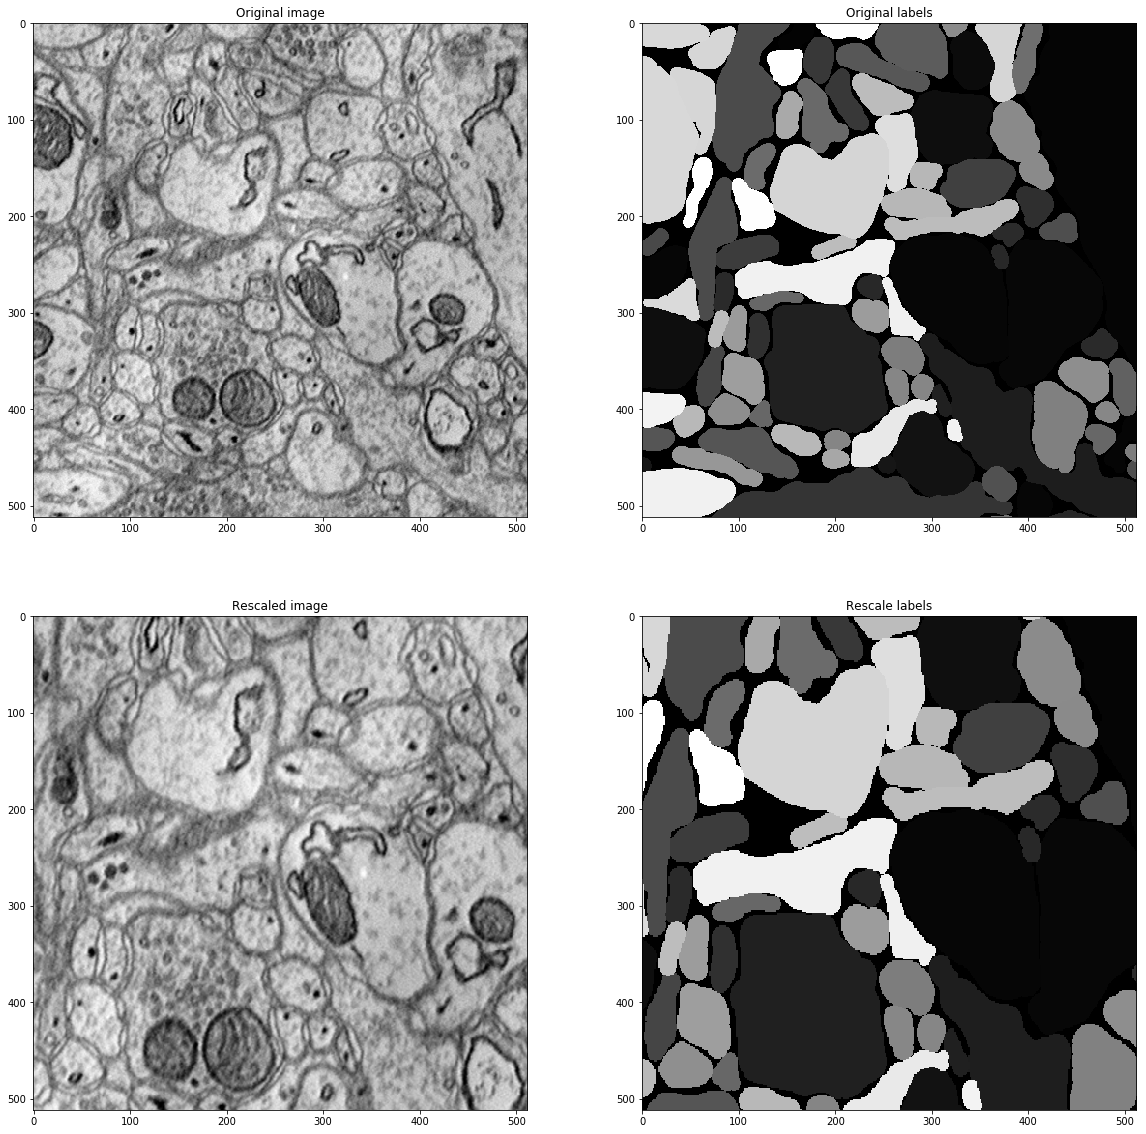

In [34]:
img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])

min_f = 0.5
max_f = 1.5
rescale_img, [rescale_labs] = rescale.rescale_augment(img, [labs], min_f, max_f)
img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Original image')
plt.imshow(np.squeeze(img[0]), cmap='gray')

plt.subplot(222)
plt.title('Original labels')
plt.imshow(np.squeeze(labs[0]), cmap='gray')

plt.subplot(223)
plt.title('Rescaled image')
plt.imshow(np.squeeze(rescale_img[0]), cmap='gray')

plt.subplot(224)
plt.title('Rescale labels')
plt.imshow(np.squeeze(rescale_labs[0]), cmap='gray')
plt.show()

## Rotate ##

## Rotate90 ##

## Sin ##

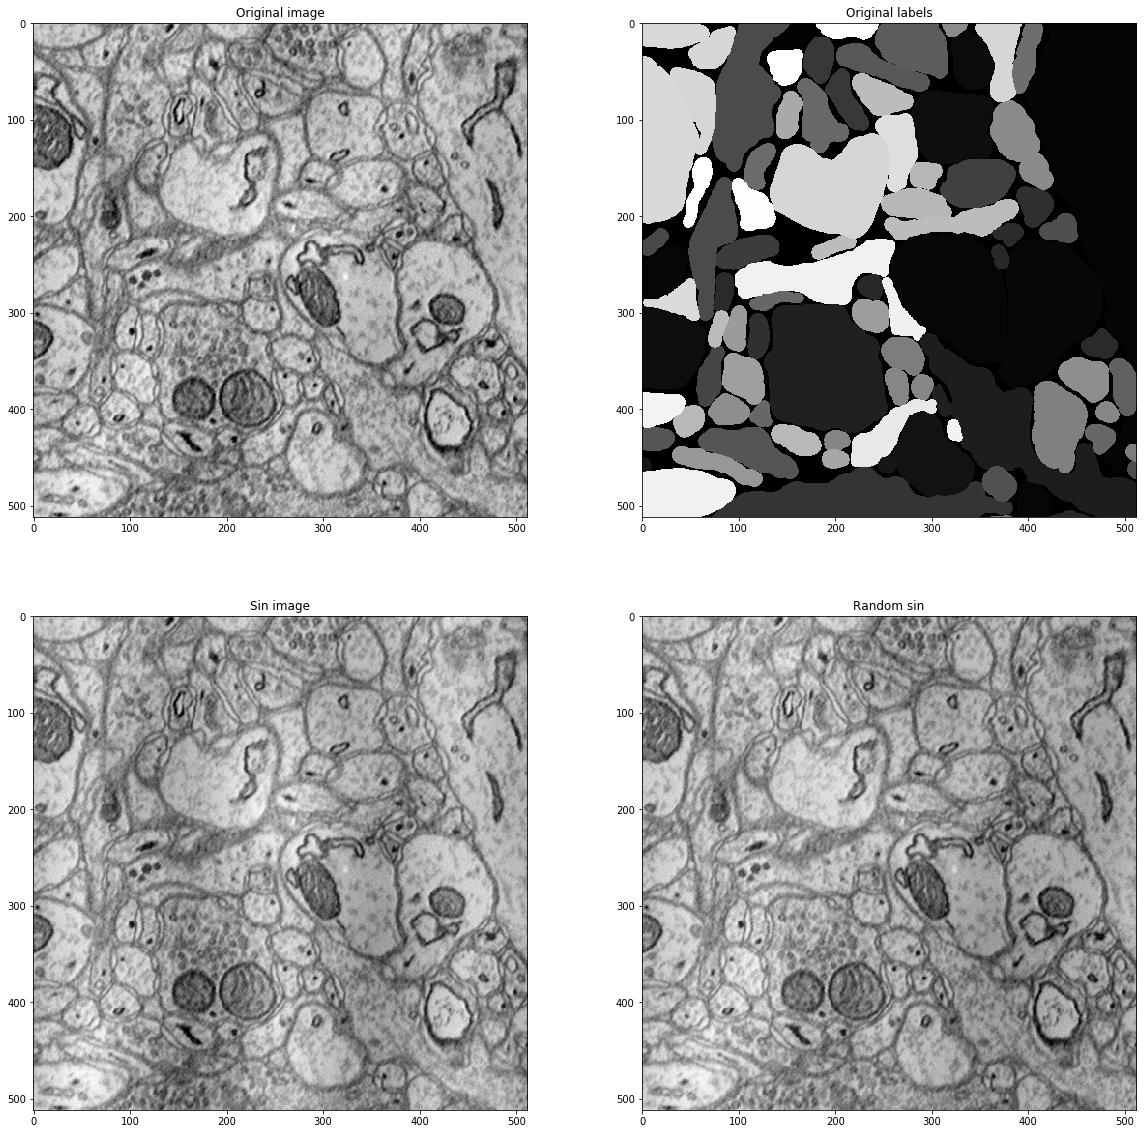

In [44]:
imgs = np.copy(volume)
imgs = imgs - np.mean(imgs)
imgs = imgs / np.std(imgs)
labs = np.copy(labels[0:3])

a = 0.5
f = 1/200.0
phi = 0.0
theta = 0.0
sin_img = sin.sin(imgs[0], a, f, phi, theta)
random_sin_img = sin.sin_augment(imgs, a, f)

img = np.copy(volume[0:3])
labs = np.copy(labels[0:3])

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Original image')
plt.imshow(np.squeeze(img[0]), cmap='gray')

plt.subplot(222)
plt.title('Original labels')
plt.imshow(np.squeeze(labs[0]), cmap='gray')

plt.subplot(223)
plt.title('Sin image')
plt.imshow(np.squeeze(sin_img), cmap='gray')

plt.subplot(224)
plt.title('Random sin')
plt.imshow(np.squeeze(random_sin_img[0]), cmap='gray')
plt.show()